<a href="https://colab.research.google.com/github/Fjoru/TM10007_PROJECT/blob/master/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment Prediction of tumor grade in brain cancer
By Jessica Barends, Gonnie van Erp, Erik Kemper en Carlijn Oerlemans



## Set-up
Getting the dataset and used packages.

In [108]:
# Run install for use in colab environment
!pip install --upgrade pip
!pip install -q --upgrade git+https://github.com/Fjoru/TM10007_PROJECT
!pip install ipdb -q
!pip install seaborn
!pip install tensorflow

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.0.2)


### Import section


In [0]:
import ipdb
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from time import time
import itertools

# General
from sklearn.model_selection import StratifiedKFold

# Preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Feature selection
from sklearn.feature_selection import RFECV

# Feature extraction
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import TruncatedSVD
import umap

# Classifiers used in random search
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

# Evaluation metrics used
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

# Optional 
#from pprint import pprint
#import tensorflow as tf
#from sklearn import preprocessing
#from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.feature_selection import SelectFromModel
#from sklearn.model_selection import cross_validate
#from sklearn.model_selection import GridSearchCV
#from sklearn.pipeline import Pipeline
#from sklearn import model_selection

### General definitions

In [0]:
def colorplot(clf, ax, x, y, h=100, precomputer=None):
    '''
    Overlay the decision areas as colors in an axes.
    
    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    features = np.c_[xx.ravel(), yy.ravel()]
    if precomputer is not None:
        if type(precomputer) is RBFSampler:
            features = precomputer.transform(features)
        elif precomputer is rbf_kernel:
            features = rbf_kernel(features, X)
            
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(features)
    else:
        Z = clf.predict_proba(features)
    if len(Z.shape) > 1:
        Z = Z[:, 1]
    
    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm

## Dataset processing
Filter the dataset for better classification results.

### Definition set
Contains all used definitions for the prepocessing of the dataset.

Load dataset

In [0]:
def load_data(splits):
  '''
  load brats database and split values from labels

  '''
  # Data loading functions.
  from brats.load_data import load_data

  data = load_data()
  print('data loaded')
  print(f'The number of samples: {len(data.index)}')
  print(f'The number of columns: {len(data.columns)}')
  data = pd.DataFrame(data)

  # split labels and values
  data_X = data.drop(columns=['label'])
  data_Y = data[['label']]
  
  # data split index forming
  Test_split = StratifiedKFold(n_splits=splits)
  
  return data_X, data_Y, Test_split

remove strings from data

In [0]:
def replace_str(i):
    '''Function to set strings into NaN within a matrix'''

    if isinstance(i, int):
          return i
    try:
        float(i)
        return float(i)
    except:
        return np.nan

remove zeros and Inf from matrix

In [0]:
def replace_inf(X_data):
    # set 0.0 as NaN
    X_data.replace(0, np.nan, inplace=True)

    # set Inf as NaN
    X_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    return X_data

remove samples with less than 60% values

In [0]:
def remove_sample(X_data, Y_data, n_value):
    # remove sample with less than n% values
    X_data = X_data.dropna(thresh=round(X_data.shape[1]*n_value))
    Y_data = Y_data.loc[X_data.index]

    return X_data, Y_data

remove samples without a label

In [0]:
def remove_labeless(X_data, Y_data):
    # remove samples without a label
    Y_data['label'].replace(np.nan, '', inplace=True)
    Y_data = Y_data[Y_data['label'].astype(bool)]
    X_data = X_data.loc[Y_data.index]

    return X_data, Y_data

Impute missing value's

In [0]:
def impute_data(X_data):
    # Add missing value's 
    Imputer = IterativeImputer(sample_posterior=True, n_nearest_features=20, random_state=0)
    X_data = Imputer.fit_transform(X_data)

    return X_data, Imputer

Scale value's

In [0]:
def scale_data(X_data):
    # scaling of values
    Scaler = RobustScaler()
    X_data = Scaler.fit_transform(X_data)

    return X_data, Scaler

### preform dataset processing
Run all preset definitions.

In [0]:
def preprocessing_data(X_design, Y_design, X_test, Y_test):
    '''
    Preprocessing step Hyperparameters:
    - Feature removal percentage
    - Sample removal percentage
    - Value imputer type
    - Normalizer type
    '''

    # remove strings from data
    X_design = X_design.applymap(func=replace_str)
    X_test = X_test.applymap(func=replace_str)

    # remove 0.0 and Inf from data
    X_design = replace_inf(X_design)
    X_test = replace_inf(X_test)
    print('unusefull values removed')

    # remove features with less than 60% values
    X_design = X_design.dropna(thresh=round(X_design.shape[0]*0.6), axis='columns')
    X_test = X_test[X_design.columns]

    # remove features and samples with less than 60% values
    X_design, Y_design = remove_sample(X_design, Y_design, n_value=0.6)
    X_test, Y_test = remove_sample(X_test, Y_test, n_value=0.6)
    print('features and samples with to little information removed')

    # remove samples without a label
    X_design, Y_design = remove_labeless(X_design, Y_design)    
    X_test, Y_test = remove_labeless(X_test, Y_test)
    print('labeless samples removed')

    # impute missing data
    X_design_imput, imputer = impute_data(X_design)
    X_test_imput = imputer.transform(X_test)
    print('remaining missing data imputed')

    # scale the data
    X_design_scaled, scaler = scale_data(X_design_imput)
    X_test_scaled = scaler.transform(X_test_imput)
    print('data scaled')

    # Getting back to Dataframe 
    X_design = pd.DataFrame(X_design_scaled, columns=X_design.columns, index=X_design.index)
    X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    print('preprocessing finished')

    return X_design, Y_design, X_test, Y_test

## Experimental feature orientation
Determine possible options for feature selection and extraction

### Load part of dataset
Getting the design set of the data.

In [119]:
#load dataset
data_X, data_Y, Test_split = load_data(splits=10)

i = 0

for design_index, test_index in Test_split.split(data_X, data_Y):

    if i:
      continue
    i = 1

    X_design = data_X.iloc[design_index]
    Y_design = data_Y.iloc[design_index]
    
    X_test = data_X.iloc[test_index]
    Y_test = data_Y.iloc[test_index]

X_design, Y_design, X_test, Y_test = preprocessing_data(X_design, Y_design, X_test, Y_test)

data loaded
The number of samples: 167
The number of columns: 725
unusefull values removed
features and samples with to little information removed
labeless samples removed
remaining missing data imputed
data scaled
preprocessing finished


In [0]:
print(X_design, Y_design)


### Feature test definitions
Pre-set definitions to preform the experiments.

Pre-sets

In [0]:
# Set paramters
RFE_split = 5
Train_split = 5

# make labels binary
Y_design_bin = Y_design.replace(['GBM', 'LGG'], [1, 0])

# set validation-training split
train_splitter = StratifiedKFold(n_splits=Train_split)

Selector

In [0]:
# RFE estimator
svc_linear = svm.SVC(kernel="linear")

# RFE type
rfecv_svc = RFECV(
                  estimator=svc_linear, step=1, 
                  cv=StratifiedKFold(n_splits=RFE_split), 
                  scoring='roc_auc')           

Extractors

In [0]:
# extractors
pca_lin = KernelPCA(kernel='linear')
pca_poly = KernelPCA(kernel='poly')
pca_rbf = KernelPCA(kernel='rbf')
umapper_3 = umap.UMAP(n_neighbors=3)
umapper_5 = umap.UMAP(n_neighbors=5)
umapper_6 = umap.UMAP(n_neighbors=6)
umapper_15 = umap.UMAP(n_neighbors=15)
umapper_30 = umap.UMAP(n_neighbors=30)
tsvd = TruncatedSVD()

Cross-validation test

In [0]:
def run_feature_test(X_design, Y_design_bin, train_splitter, para_options):
    # predefine variables
    results = list()
    i = 1
    t0 = time()

    # create standard classifier
    clf = svm.SVC()
    
    # run cross-validation validate, train set
    for train_index, validate_index in train_splitter.split(X_design, Y_design_bin):
        X_train = X_design.iloc[train_index]
        Y_train = Y_design_bin.iloc[train_index]
    
        X_validate = X_design.iloc[validate_index]
        Y_validate = Y_design_bin.iloc[validate_index]
        Y_validate = np.array(Y_validate)
        print(f'running split {i} of {Train_split}')
        i += 1

        # Run RFECV on split
        selector=rfecv_svc
        X_train_selected = selector.fit_transform(X_train, Y_train['label'])
        X_validate_selected = selector.transform(X_validate)
        print(f'{X_train_selected.shape[1]} features left after selection')

        for indez, row in para_options.iterrows():
            extractor=extractors[row[1]]
            component=row[2]
        
            # use selected or unselected data
            if selectors[row[0]] and X_train_selected.shape[1] > component:
                X_train_try = X_train_selected
                X_validate_try = X_validate_selected
                #print('rfecv done')

            else:
                X_train_try = X_train
                X_validate_try = X_validate
                #print('no rfecv done')
          
            # run selected extractor
            extractor.set_params(n_components=component)
            X_train_extracted = extractor.fit_transform(X_train_try)
            X_validate_extracted = extractor.transform(X_validate_try)
        
            # fitting standard classifier
            clf.fit(X_train_extracted, Y_train['label'])

            # Test the classifier on the test data
            scores = clf.predict(X_validate_extracted)

            # Gettin accuracy, AUC and f1-score
            accuracy = accuracy_score(Y_validate, scores)
            auc = roc_auc_score(Y_validate, scores)
            f1 = f1_score(Y_validate, scores)
            results.append({
                'accuracy': accuracy,
                'AUC': auc,
                'f1-score': f1,
                'set': f'{indez}_test'
            })

            # Test the classifier on the training data
            scores_training = clf.predict(X_train_extracted)

            # Getting the accuracy, AUC and f1-score
            accuracy = accuracy_score(Y_train, scores_training)
            auc = roc_auc_score(Y_train, scores_training)
            f1 = f1_score(Y_train, scores_training)
            results.append({
                'accuracy': accuracy,
                'AUC': auc,
                'f1-score': f1,
                'set': f'{indez}_training'
            })
        print(f'calulated options')

    # Create results dataframe
    results = pd.DataFrame(results)
    print("finished in %0.3fs" % (time() - t0))
    return results

Calculate mean and std from cross-validation

In [0]:
def cal_means(data, stats):
    stats.append({
    'ac mean': data["accuracy"].mean(),
    'ac std': data["accuracy"].std(),
    'AUC mean': data["AUC"].mean(),
    'AUC std': data["AUC"].std(),
    'f1 mean': data["f1-score"].mean(),
    'f1 std': data["f1-score"].std()
    })
    
    return stats

### Orientational Experiment
Experiment with a wide variety of chosen extractors and parameters to find optima.

selected options

In [0]:
# RFE types list                  
selectors = {'no_rfecv': 0, 'rfecv': 1}

# extractor list
extractors = {'umap_3': umapper_3, 'umap_5': umapper_5, 'umap_15': umapper_15, 'umap_30': umapper_30, 'pca_lin': pca_lin, 'pca_poly': pca_poly, 'pca_rbf': pca_rbf, 'tsvd': tsvd}

#component parameters
extract_components = (2, 6, 12, 24, 48, 92)

preform feature selection and extraction test

In [126]:
#all options to test
para_options = pd.DataFrame(list(itertools.product(selectors, extractors, extract_components)))
print(f'{para_options.shape[0]} options to try')

# Run experiment
results = run_feature_test(X_design, Y_design_bin, train_splitter, para_options)

96 options to try
running split 1 of 5
126 features left after selection
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
rfecv done


/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


rfecv done


/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


rfecv done


/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


rfecv done


/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


rfecv done


/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


rfecv done


/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
calulated options
running split 2 of 5
64 features left after selection
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no r

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


rfecv done


/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


rfecv done


/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


rfecv done


/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


rfecv done


/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


no rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
no rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
no rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
no rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
no rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
no rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
no rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
rfecv done
no rfecv done
calulated options
running split 3 of 5
114 features left after selection
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv done
no rfecv d

KeyboardInterrupt: ignored

Plot results

legend
           0       1   2
0   no_rfecv  umap_3   2
1   no_rfecv  umap_3   6
2   no_rfecv  umap_3  12
3   no_rfecv  umap_3  24
4   no_rfecv  umap_3  48
..       ...     ...  ..
91     rfecv    tsvd   6
92     rfecv    tsvd  12
93     rfecv    tsvd  24
94     rfecv    tsvd  48
95     rfecv    tsvd  92

[96 rows x 3 columns]


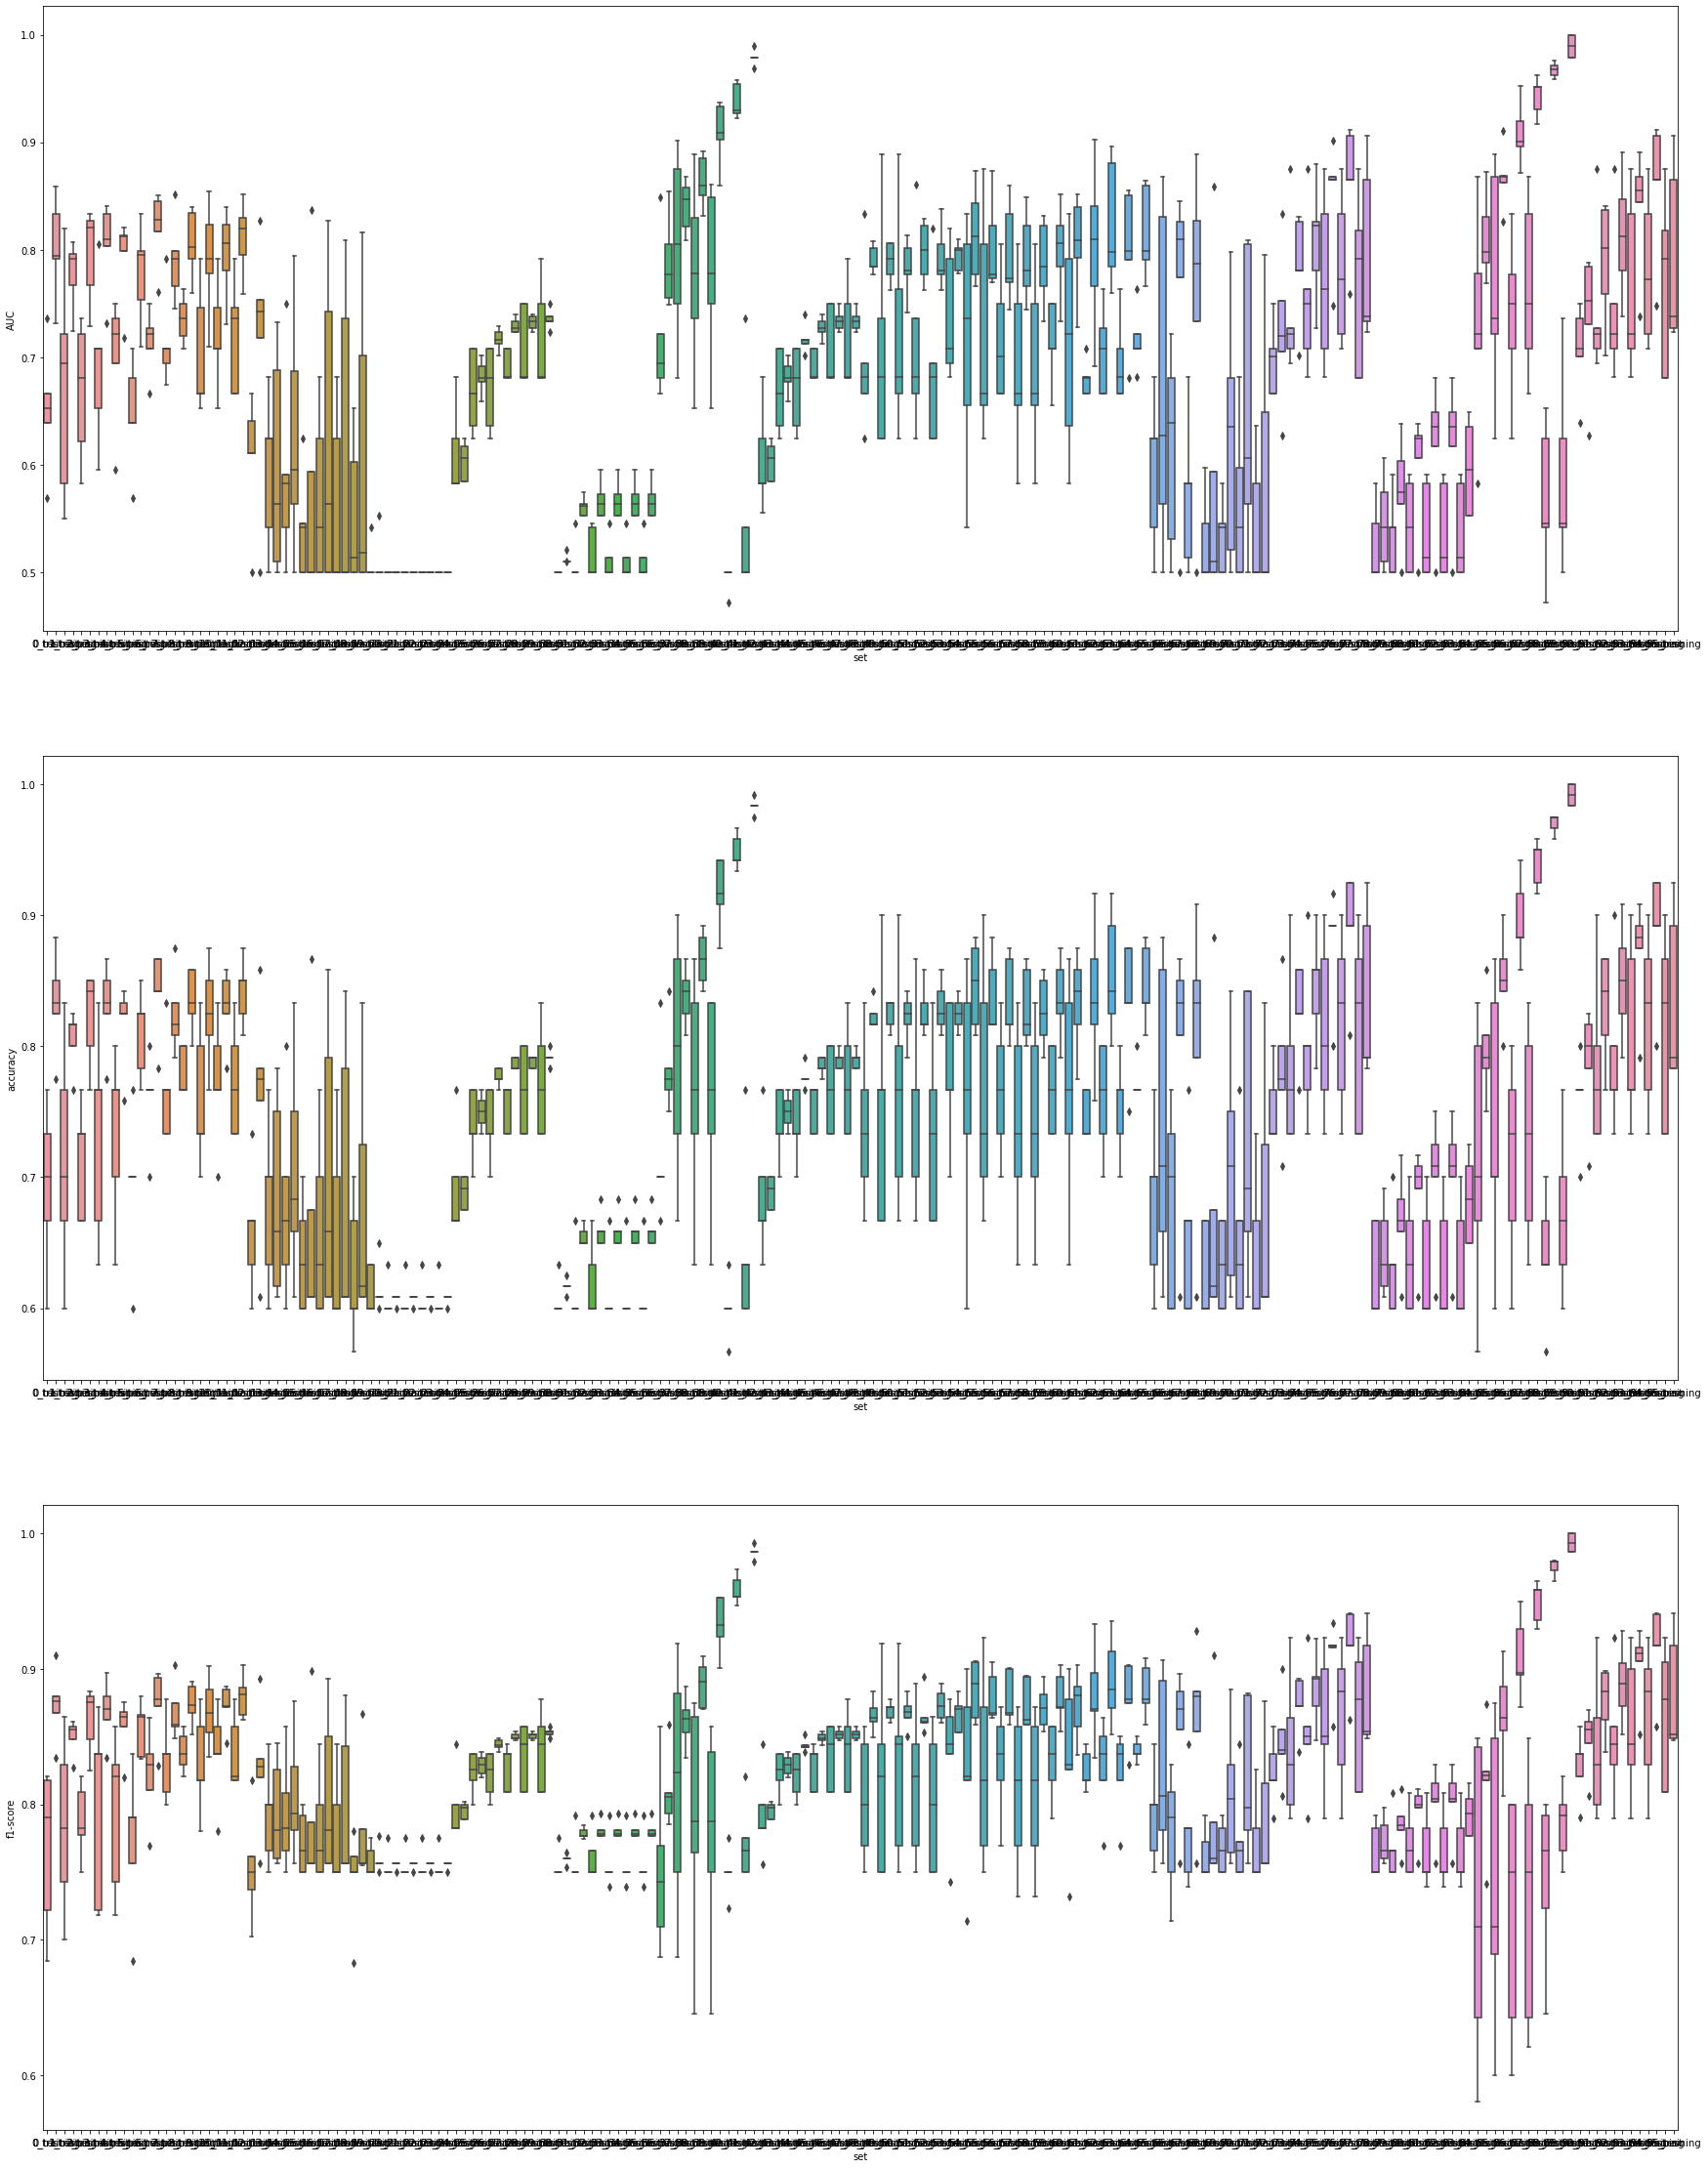

In [78]:
# plot resulting data
print('legend')
print(para_options)

f, axes = plt.subplots(3, 1, figsize=(30, 40))
sns.boxplot(y='AUC', x='set', data=results, ax=axes[0])
sns.boxplot(y='accuracy', x='set', data=results, ax=axes[1])
sns.boxplot(y='f1-score', x='set', data=results, ax=axes[2])

Determ the best options

In [79]:
# calculate the mean and std of each option
test_result_stat = list()
train_result_stat = list()

for i in range(0, para_options.shape[0]):

    test_result = results[results['set'] == f'{i}_test']
    test_result_stat = cal_means(test_result, test_result_stat)

    train_result = results[results['set'] == f'{i}_train']
    train_result_stat = cal_means(train_result, train_result_stat)

test_result_stat = pd.DataFrame(test_result_stat)
train_result_stat = pd.DataFrame(train_result_stat)

# order the results on AUC, accuracy and f1-score
test_result_stat.sort_values(by=['AUC mean', 'ac mean', 'f1 mean'],ascending=False, inplace=True)
test_result_stat = test_result_stat.join(para_options)
print('Top 20 best scoring results')
print(test_result_stat.iloc[range(0,20)])

    #'clf__max_iter': (20,),
    #'clf__alpha': (0.00001, 0.000001),
    #'clf__penalty': ('l2', 'elasticnet'),

     ac mean    ac std  AUC mean   AUC std  ...    f1 std         0        1   2
37  0.793333  0.095452  0.802605  0.090520  ...  0.094680  no_rfecv  pca_rbf   6
76  0.820000  0.069121  0.782323  0.071361  ...  0.054611     rfecv  pca_lin  48
94  0.820000  0.069121  0.782323  0.071361  ...  0.054611     rfecv     tsvd  48
39  0.760000  0.082999  0.778190  0.084340  ...  0.084339  no_rfecv  pca_rbf  24
38  0.766667  0.091287  0.777140  0.090065  ...  0.092765  no_rfecv  pca_rbf  12
75  0.813333  0.069121  0.772475  0.081581  ...  0.052165     rfecv  pca_lin  24
77  0.813333  0.076739  0.769192  0.086333  ...  0.053102     rfecv  pca_lin  92
95  0.813333  0.076739  0.769192  0.086333  ...  0.053102     rfecv     tsvd  92
85  0.740000  0.109036  0.768129  0.109841  ...  0.115048     rfecv  pca_rbf   6
87  0.733333  0.084984  0.765351  0.084366  ...  0.098555     rfecv  pca_rbf  24
93  0.806667  0.072265  0.764141  0.084744  ...  0.054086     rfecv     tsvd  24
74  0.800000  0.062361  0.75

In [65]:
optimal_comb = para_options.loc[test_result_stat.index[9]]
print("The optimal combination =")
print(optimal_comb)

The optimal combination =
0      rfecv
1    pca_rbf
2         24
Name: 87, dtype: object


After running the code above, the following conclusions where drawn:
- There is difference between feature and no feature selection, but not similar for each option
- the PCA with a rbf kernel and no rfecv provides the highest scores, but with a high std
- the PCA with a linear kernel and rfecv also provide high scores and lower std, but only with more components
- the UMAP with 5 neighbors provides second best scores, but with a smaller std
- there is a optimum in the amount of components around the 6 and 12

With this in mind the parameter for the second test are chosen.

### Localized Experiment
Experiment with selected extractors and parameters around promising results of the Orientational Experiment.

selected options

In [0]:
# RFE types list                  
selectors = {'no_rfecv': 0, 'rfecv': 1}

# extractor list
extractors = {'umap_5': umapper_5, 'pca_lin': pca_lin, 'pca_rbf': pca_rbf}

#parameters
extract_components = (4, 6, 8, 12, 45, 48, 52, 56)

preform feature selection and extraction test

In [105]:
#all options to test
para_options = pd.DataFrame(list(itertools.product(selectors, extractors, extract_components)))
para_options = para_options.loc[[0,1,2,3,16,17,18,19,36,37,38,39]]
para_options = para_options.reset_index(drop=True)
print(f'{para_options.shape[0]} options to try')

# Run experiment
results = run_feature_test(X_design, Y_design_bin, train_splitter, para_options)

12 options to try
           0        1   2
0   no_rfecv   umap_5   4
1   no_rfecv   umap_5   6
2   no_rfecv   umap_5   8
3   no_rfecv   umap_5  12
4   no_rfecv  pca_rbf   4
5   no_rfecv  pca_rbf   6
6   no_rfecv  pca_rbf   8
7   no_rfecv  pca_rbf  12
8      rfecv  pca_lin  45
9      rfecv  pca_lin  48
10     rfecv  pca_lin  52
11     rfecv  pca_lin  56
running split 1 of 5
126 features left after selection
calulated options
running split 2 of 5
64 features left after selection
calulated options
running split 3 of 5
114 features left after selection
calulated options
running split 4 of 5
84 features left after selection
calulated options
running split 5 of 5
55 features left after selection
calulated options
finished in 165.725s


Plot results

legend
           0        1   2
0   no_rfecv   umap_5   4
1   no_rfecv   umap_5   6
2   no_rfecv   umap_5   8
3   no_rfecv   umap_5  12
4   no_rfecv  pca_rbf   4
5   no_rfecv  pca_rbf   6
6   no_rfecv  pca_rbf   8
7   no_rfecv  pca_rbf  12
8      rfecv  pca_lin  45
9      rfecv  pca_lin  48
10     rfecv  pca_lin  52
11     rfecv  pca_lin  56


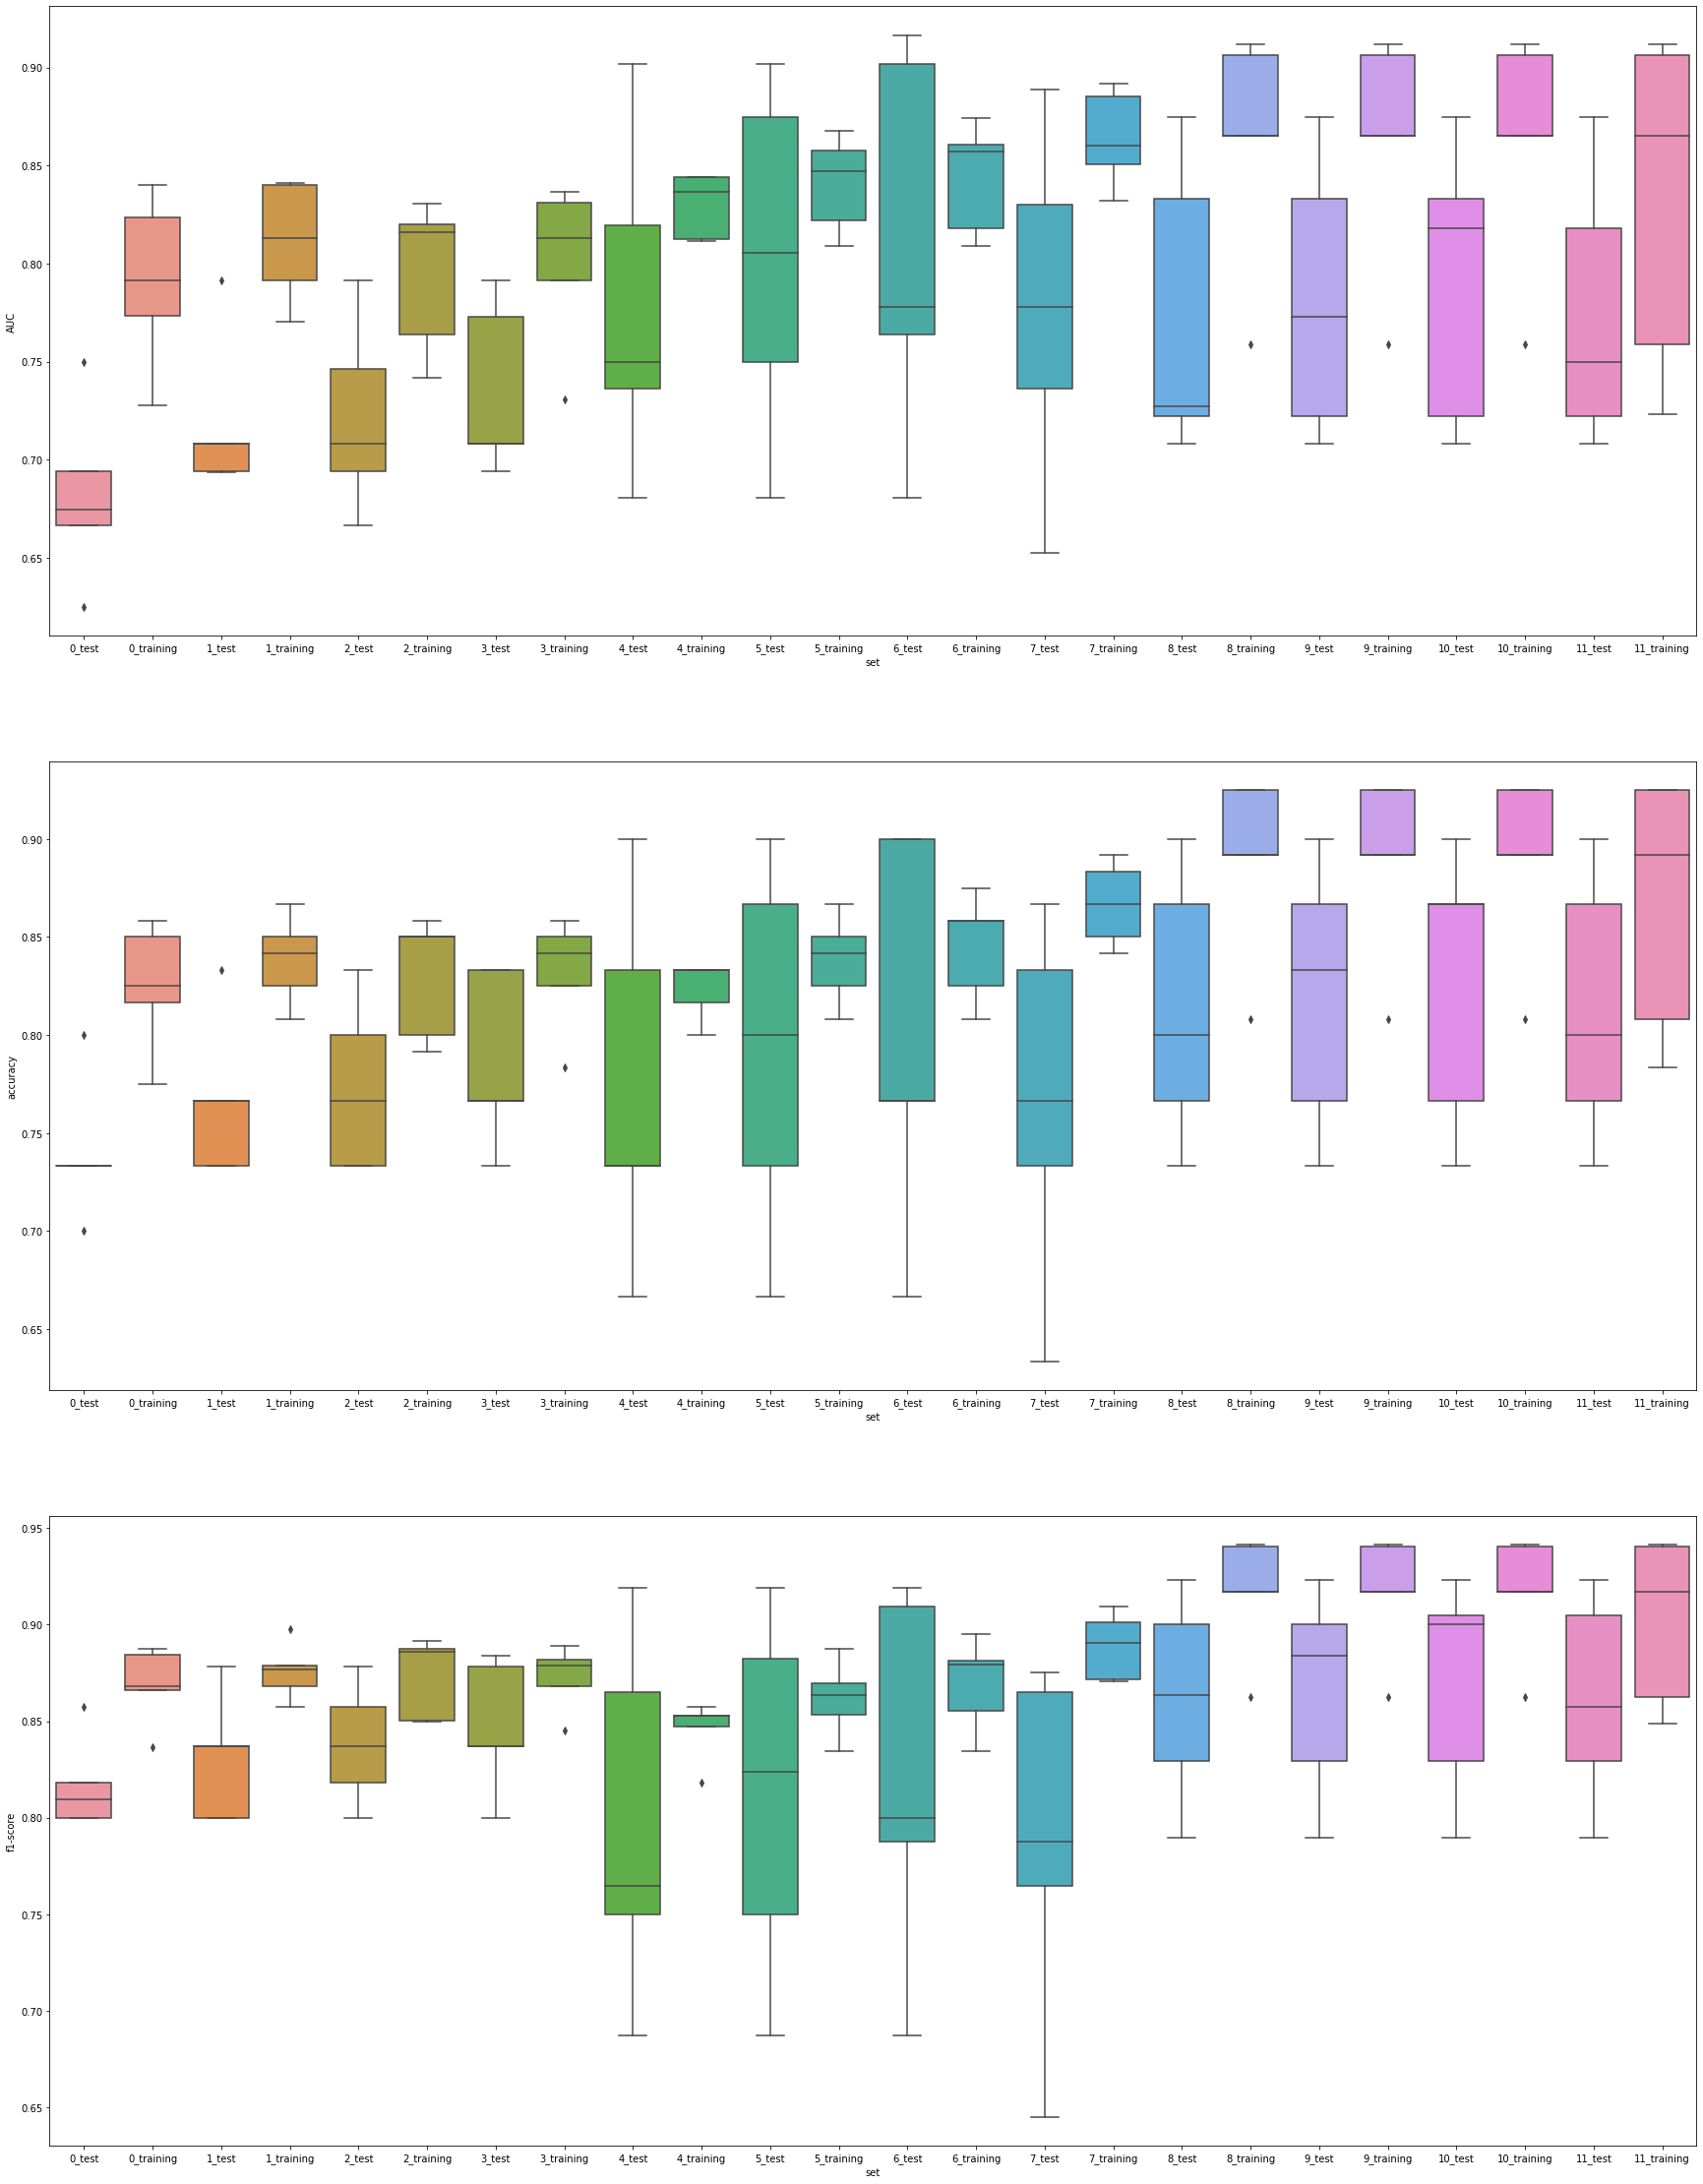

In [106]:
# plot resulting data
print('legend')
print(para_options)

f, axes = plt.subplots(3, 1, figsize=(30, 40))
sns.boxplot(y='AUC', x='set', data=results, ax=axes[0])
sns.boxplot(y='accuracy', x='set', data=results, ax=axes[1])
sns.boxplot(y='f1-score', x='set', data=results, ax=axes[2])

Determ the best options

In [107]:
# calculate the mean and std of each option
test_result_stat = list()
train_result_stat = list()


for i in range(0, para_options.shape[0]):

    test_result = results[results['set'] == f'{i}_test']
    test_result_stat = cal_means(test_result, test_result_stat)

    train_result = results[results['set'] == f'{i}_train']
    train_result_stat = cal_means(train_result, train_result_stat)

test_result_stat = pd.DataFrame(test_result_stat)
train_result_stat = pd.DataFrame(train_result_stat)

# order the results on AUC, accuracy and f1-score
test_result_stat.sort_values(by=['AUC mean', 'ac mean', 'f1 mean',],ascending=False, inplace=True)
print(test_result_stat)

    #'clf__max_iter': (20,),
    #'clf__alpha': (0.00001, 0.000001),
    #'clf__penalty': ('l2', 'elasticnet'),

     ac mean    ac std  AUC mean   AUC std   f1 mean    f1 std
6   0.800000  0.100000  0.808161  0.099661  0.820678  0.095796
5   0.793333  0.095452  0.802605  0.090520  0.812460  0.094680
10  0.826667  0.072265  0.791414  0.072716  0.869316  0.057155
9   0.820000  0.069121  0.782323  0.071361  0.865108  0.054611
4   0.773333  0.092496  0.777605  0.085302  0.797198  0.093156
7   0.766667  0.091287  0.777140  0.090065  0.787522  0.092765
11  0.813333  0.069121  0.774747  0.070213  0.860745  0.054558
8   0.813333  0.069121  0.773232  0.075655  0.861091  0.053629
3   0.786667  0.044721  0.735101  0.043879  0.847238  0.034325
2   0.773333  0.043461  0.721505  0.048621  0.838117  0.030853
1   0.766667  0.040825  0.719312  0.041069  0.830493  0.032448
0   0.740000  0.036515  0.682150  0.045599  0.816970  0.023700


Based on these results the following is concluded:
- the PCA with rbf kernal and 6 or 8 components has the best AUC score, but still a high std
- the PCA with linear kernal and 48/52 components has the best Accuracy and f1-score, with a lower std
- the UMAP with 5 neighbors and 6 or 8 components has similar score for accuracy and f1, but a lower score for AUC and similar the std as the linear PCA.



### Conclusion

We will let the model optimization choose from:
- PCA (Kernel:linear, Components:48/52, rfecv)
- PCA (Kernel:rbf, Components:6/8)
- UMAP (Neigbors:5, Components:6/8)

## Final machine learning pipeline
Our resulting machine learning model for tumor grading in brain cancer.

As described in the enclosed document are the following steps en parameter settings the by us found most optimale for optimising and classifing the given dataset.

### Feature extraction

Feature extraction with hyperparameters based on previous experiments

Feature extraction optimalisation

In [0]:
def run_feature_extraction_test(X_design, Y_design_bin, train_splitter, para_options):
    # predefine variables
    results = list()
    i = 1
    t0 = time()

    # create standard classifier
    clf = svm.SVC()
    
    # run cross-validation validate, train set
    for train_index, validate_index in train_splitter.split(X_design, Y_design_bin):
        X_train = X_design.iloc[train_index]
        Y_train = Y_design_bin.iloc[train_index]
    
        X_validate = X_design.iloc[validate_index]
        Y_validate = Y_design_bin.iloc[validate_index]
        Y_validate = np.array(Y_validate)
        print(f'running split {i} of {Train_split}')
        i += 1

        for indez, extractor in enumerate(para_options):
            
            if extractor == pca_48 or extractor == pca_52:
                # Run RFECV on split
                selector=rfecv_svc
                X_train = selector.fit_transform(X_train, Y_train['label'])
                X_validate = selector.transform(X_validate)
                print(f'{X_train_selected.shape[1]} features left after selection')
          
            # run selected extractor
            X_train_extracted = extractor.fit_transform(X_train)
            X_validate_extracted = extractor.transform(X_validate)
        
            # fitting standard classifier
            clf.fit(X_train_extracted, Y_train['label'])

            # Test the classifier on the test data
            scores = clf.predict(X_validate_extracted)

            # Gettin accuracy, AUC and f1-score
            accuracy = accuracy_score(Y_validate, scores)
            auc = roc_auc_score(Y_validate, scores)
            f1 = f1_score(Y_validate, scores)
            results.append({
                'accuracy': accuracy,
                'AUC': auc,
                'f1-score': f1,
                'set': f'{indez}_test'
            })

            # Test the classifier on the training data
            scores_training = clf.predict(X_train_extracted)

            # Getting the accuracy, AUC and f1-score
            accuracy = accuracy_score(Y_train, scores_training)
            auc = roc_auc_score(Y_train, scores_training)
            f1 = f1_score(Y_train, scores_training)
            results.append({
                'accuracy': accuracy,
                'AUC': auc,
                'f1-score': f1,
                'set': f'{indez}_training'
            })
        print(f'calulated options')

    # Create results dataframe
    results = pd.DataFrame(results)
    print("finished in %0.3fs" % (time() - t0))
    return results

Feature extraction

In [0]:
def feature_extraction(X_design, Y_design, X_test, Y_test):
    '''
    Feature steps Hyperparameters:
    Feature extraction:
    - UMAP
      - numb of resulting features
      - numb of used neighbors
    '''

    # generate binary labels 
    Y_design_bin = Y_design.replace(['GBM', 'LGG'], [1, 0])
    Y_Test_bin = Y_design.replace(['GBM', 'LGG'], [1, 0])
    
    # Create extraction models
    Umapper_6 = umap.UMAP(n_neighbors=5, n_components=6)
    Umapper_8 = umap.UMAP(n_neighbors=5, n_components=8)
    pca_6 = KernelPCA(kernel='rbf', n_components=6)
    pca_8 = KernelPCA(kernel='rbf', n_components=8)
    pca_48 = KernelPCA(kernel='lin', n_components=48)
    pca_52 = KernelPCA(kernel='lin', n_components=52)

    # Set paramters
    RFE_split = 5
    Train_split = 5

    # RFE estimator
    svc_linear = svm.SVC(kernel="linear")

    # RFE type
    rfecv_svc = RFECV(
                      estimator=svc_linear, step=1, 
                      cv=StratifiedKFold(n_splits=RFE_split), 
                      scoring='roc_auc')           

    # set validation-training split
    train_splitter = StratifiedKFold(n_splits=Train_split)

    # list extraction options
    para_options = (Umapper_6, Umapper_8, pca_6, pca_8, pca_48, pca_52)
    para_options.append({
                'accuracy': accuracy,
                'AUC': auc,
                'f1-score': f1,
                'set': f'{indez}_test'
            })
    print(f'{para_options.shape[0]} options to try')
    print(para_options)

    # Run experiment
    results = run_feature_extraction_test(X_design, Y_design_bin, train_splitter, para_options)

    # select best extractor
    best_extractor = results[0]
    extractor = para_options[best_extractor]
    
    # Preform model fitting and transformation
    X_design = extractor.fit_transform(X_design)
    X_design = pd.DataFrame(X_design, index=Y_design.index)

    X_test = extractor.transform(X_test)
    X_test = pd.DataFrame(X_test, index=Y_test.index)


    

    # combine data and labels
    #df = pd.DataFrame(data=X_design, index=Y_design_bin.index)
    #df = df.join(Y_design_bin)

    # generate pairplot
    #pp = sns.pairplot(df[:], hue='label', size=1.8, aspect=1.8, 
    #                  palette={0: "#9966FF", 1: "#FFE888"},
    #                  plot_kws=dict(edgecolor="black", linewidth=0.5))
    #fig = pp.fig 
    #fig.subplots_adjust(top=0.93, wspace=0.3)
    #t = fig.suptitle('Feature Attributes Pairwise Plots', fontsize=14)

    return X_design, Y_design_bin, X_test, Y_test_bin, best_extractor

### Classifier

In [0]:
def classifiers (X_design, Y_design, X_test, Y_test):
    global results
    global best_parameters
   
    ## Example for Classifier hyperparameters selecting
    clfs = {svm.SVC(probability=True): {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': range(1,5,1)},
            RandomForestClassifier(): {'n_estimators':range(1,400,5)},
            KNeighborsClassifier() : {'n_neighbors': range(1,100,2), 'weights': ['uniform', 'distance']},
            LinearDiscriminantAnalysis():{}
            }
    names = ['SVC', 'RandomForest', 'KNN', 'LinearDiscriminant']
    n = 0
  
    for clf, parameters in clfs.items():
        scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'f1-score': make_scorer(f1_score)}

        random_search = RandomizedSearchCV(clf, parameters, scoring=scoring, refit='AUC', cv=None) ## hierin zit al de crossvalidatie, dus opnieuw een k-fold split hoeft niet #keuze om score voor alle classifiers gelijk te houden of per classifier te definieren
        random_search.fit(X_design, Y_design)

        # Get resulting classifier
        clf_best = random_search.best_estimator_
        print(f'Best classifier: parameters={random_search.best_params_}')
        best_parameters.append(random_search.best_params_)   #per fold best classifier will be appended
        scores = random_search.best_score_
        print(random_search.cv_results_)
        print (scores)

        if n == 0:
          clf_name = names[0]
        elif n % 4 == 1:
          clf_name = names[1]
        elif n % 4 == 2:
          clf_name = names[2]
        elif n % 4 == 3:
          clf_name = names[3]
        elif n % 4 == 0:
          clf_name = names[0]
        n += 1 
    
        # Getting the accuracy, AUC and f1-score
        accuracy = random_search.cv_results_['mean_test_Accuracy'][random_search.best_index_]
        auc = random_search.cv_results_['mean_test_AUC'][random_search.best_index_]
        f1 = random_search.cv_results_['mean_test_f1-score'][random_search.best_index_]
        mean_score = (accuracy + auc + f1)/3
        results.append({
            'accuracy': accuracy,
            'AUC': auc,
            'f1-score': f1,
            'mean_score': mean_score,
            'clf_name': clf_name,
            'clf': clf_best, 
            'parameters': random_search.best_params_,
            'set': 'validation'
              })
        
    # Create results dataframe and plot it
    results = pd.DataFrame(results)
    print(results)
    sns.boxplot(y='AUC', x='clf_name', data=results)
    sns.boxplot(y='accuracy', x='clf_name', data=results)
    sns.boxplot(y='f1-score', x='clf_name', data=results)

    index_best_classifier = results[['mean_score']].idxmax() 
    print(f'index_best_classifier={index_best_classifier}')
    best_classifier_name = results['clf_name'][index_best_classifier]
    best_classifier_name = best_classifier_name.tolist()
    best_classifier = results['clf'][index_best_classifier]   
    best_classifier = best_classifier.tolist()
    print(f'best_classifier={best_classifier}')

    # Train best classifier on total testdata
    classifier_optimized = best_classifier[0].fit(X_design,Y_design)
    pred_train = classifier_optimized.predict(X_design)

    #Gettin accuracy, AUC and f1-score
    accuracy_train = accuracy_score(Y_design, pred_train)
    auc_train = roc_auc_score(Y_design, pred_train)
    f1_train = f1_score(Y_design, pred_train)
    results_outer.append({
        'accuracy': accuracy_train,
        'AUC': auc_train,
        'f1-score': f1_train,
        'clf': best_classifier[0],
        'clf_name': best_classifier_name[0],
        'set': 'training'
        })
    
    #Test the classifier on the test data
    pred_test = classifier_optimized.predict(X_test)

    #Gettin accuracy, AUC and f1-score
    accuracy_test = accuracy_score(Y_test, pred_test)
    auc_test = roc_auc_score(Y_test, pred_test)
    f1_test = f1_score(Y_test, pred_test)
    results_outer.append({
        'accuracy': accuracy_test,
        'AUC': auc_test,
        'f1-score': f1_test,
        'clf': best_classifier[0],
        'clf_name': best_classifier_name[0],
        'set': 'testing'
        })

    
    return results, results_outer

### Pipeline

In [0]:
#load dataset
data_X, data_Y, Test_split = load_data(splits=10)

results = list()
best_parameters = list()
results_outer = list()

for design_index, test_index in Test_split.split(data_X, data_Y):

    X_design = data_X.iloc[design_index]
    Y_design = data_Y.iloc[design_index]
    
    X_test = data_X.iloc[test_index]
    Y_test = data_Y.iloc[test_index]

    # run preprocessing
    X_design, Y_design, X_test, Y_test = preprocessing_data(X_design, Y_design, X_test, Y_test)

    #run feature extraction
    X_design, Y_design_bin, X_test, Y_test_bin, feature_extractor = feature_extraction(X_design, Y_design, X_test, Y_test)

    # run classifier
    results, results_outer = classifiers (X_design, Y_design_bin, X_test, Y_test)
  
# Selecting best overall classifier   
results_outer = pd.DataFrame(results_outer)
print(results_outer)

optimal_classifier = str(results_outer.median['clf_name'])
print(f"The optimal classifier={optimal_classifier}")

# save data to csv for manual check
#X_design.to_csv('data_X.csv')
#Y_design.to_csv('data_Y.csv')



### Result